# Extended Fama-French Strategies — Experiment

Unified notebook that loads multiple Fama-French strategy families via `finance_data.french`, then feeds them into the shared Sharpe/PSR/DSR/MinTRL/oFDR helpers.


In [1]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path("..") / "src"))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from finance_data.datasets import ensure_french_datasets
from finance_data.french import load_all_strategies_long, load_us_research_factors_wide, pivot_family
from finance_data.metrics import (
    sharpe_ratio,
    sample_skewness,
    sample_kurtosis,
    probabilistic_sharpe_ratio,
    deflated_sharpe_ratio,
    min_track_record_length,
    observed_fdr,
    effective_num_tests,
)

DATA_DIR = Path("../data")
datasets = ensure_french_datasets(output_dir=DATA_DIR, refresh=False)
all_strategies = load_all_strategies_long(start_date="1926-01-01", end_date="2025-12-31")
print("Loaded strategies by group:")
display(all_strategies.groupby("group")["strategy_id"].nunique())


/workspaces/finance-data-download-test/notebooks/../src/finance_data/french.py:58: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fetched = web.DataReader(dataset, "famafrench", start=pdr_start, end=pdr_end)
/workspaces/finance-data-download-test/notebooks/../src/finance_data/french.py:58: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fetched = web.DataReader(dataset, "famafrench", start=pdr_start, end=pdr_end)
/workspaces/finance-data-download-test/notebooks/../src/finance_data/french.py:58: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datet

Loaded strategies by group:


group
Global_size_BM_25     25
US_factors_5           5
US_industries_30      30
US_industries_49      49
US_momentum_factor     1
US_size_10            10
US_size_BM_25         25
Name: strategy_id, dtype: int64

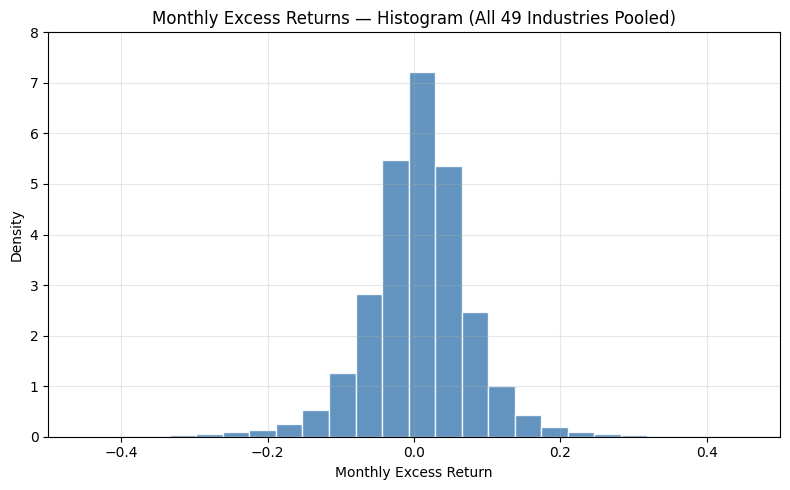

In [2]:
ind49_wide = pivot_family(all_strategies, ["US_industries_49"])
vals = pd.concat([ind49_wide[c].astype(float).dropna() for c in ind49_wide.columns])
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(vals.values, bins=100, density=True, color='steelblue', alpha=0.85, edgecolor='white')
ax.set_title('Monthly Excess Returns — Histogram (All 49 Industries Pooled)')
ax.set_xlabel('Monthly Excess Return')
ax.set_ylabel('Density')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0.0, 8.0)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# Market Sharpe as null benchmark (Mkt-RF)
ff_factors, rf_series = load_us_research_factors_wide(start_date="1926-07-01")
ff_factors.index = pd.to_datetime(ff_factors.index).to_period("M").to_timestamp("M")
market_excess = ff_factors["Mkt-RF"].rename("Mkt_RF")
SR_MARKET = sharpe_ratio(market_excess)
print(f"Market SR (Mkt-RF) benchmark: {SR_MARKET:.4f} over {market_excess.dropna().shape[0]} months")


Market SR (Mkt-RF) benchmark: 0.1303 over 1191 months


/workspaces/finance-data-download-test/notebooks/../src/finance_data/french.py:58: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fetched = web.DataReader(dataset, "famafrench", start=pdr_start, end=pdr_end)
/workspaces/finance-data-download-test/notebooks/../src/finance_data/french.py:58: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fetched = web.DataReader(dataset, "famafrench", start=pdr_start, end=pdr_end)


In [4]:
family_definitions = {
    "US_industries_49": ["US_industries_49"],
    "US_industries_30": ["US_industries_30"],
    "US_factors_and_momentum": ["US_factors_5", "US_momentum_factor"],
    "US_size_10": ["US_size_10"],
    "US_size_BM_25": ["US_size_BM_25"],
    "Global_size_BM_25": ["Global_size_BM_25"],
}


def analyze_family(family_name, groups, conf=0.95, prior_h1=0.10, sr_alt=0.50, sr_benchmark=0.0):
    wide = pivot_family(all_strategies, groups)
    k_raw = wide.shape[1]
    k_eff = effective_num_tests(wide)
    k_use = k_eff if np.isfinite(k_eff) and k_eff > 1 else k_raw

    rows = []
    for col in wide.columns:
        r = wide[col].dropna()
        psr, sr_hat = probabilistic_sharpe_ratio(r, sr_benchmark=sr_benchmark, mode="paper")
        dsr, sr_hat2, sr0 = deflated_sharpe_ratio(r, m_eff=k_use, mode="paper")
        mintrl = min_track_record_length(
            r,
            sr_benchmark=sr_benchmark,
            conf_level=conf,
            periods_per_year=12,
            m_eff=k_use,
        )
        ofdr = observed_fdr(
            r,
            sr_benchmark=sr_benchmark,
            sr_alt=sr_alt,
            prior_h1=prior_h1,
            m_eff=k_use,
        )
        rows.append(
            {
                "family": family_name,
                "strategy_id": col,
                "n_obs": r.shape[0],
                "SR": sr_hat,
                "skew": sample_skewness(r),
                "kurt": sample_kurtosis(r),
                "PSR_benchmark": psr,
                "DSR": dsr,
                "MinTRL_obs": mintrl.get("min_obs"),
                "MinTRL_years": mintrl.get("min_years"),
                "oFDR": ofdr.get("ofdr"),
                "SR0_used": sr0,
                "K_raw": k_raw,
                "K_eff": k_eff,
                "SR_benchmark": sr_benchmark,
            }
        )

    result = pd.DataFrame(rows).sort_values("SR", ascending=False)
    result["p_PSR_benchmark"] = 1.0 - result["PSR_benchmark"]
    result["p_DSR"] = 1.0 - result["DSR"]
    result.attrs.clear()
    return result


## Family-level Sharpe diagnostics

Use the existing Sharpe/PSR/DSR/MinTRL/oFDR routines on each family, tracking both raw K and K_eff from the correlation structure.

In [5]:
family_tables = []
family_results = {}
for fam_name, groups in family_definitions.items():
    res = analyze_family(fam_name, groups, sr_benchmark=SR_MARKET)
    res = res.copy()
    family_tables.append(res)
    family_results[fam_name] = res
    print(f"{fam_name}: K_raw={res['K_raw'].iloc[0]} | K_eff={res['K_eff'].iloc[0]}")
    display(res.head(10))

results_all = pd.concat(family_tables, ignore_index=True)
results_all.head()


US_industries_49: K_raw=49 | K_eff=2.7759180416718756


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
39,US_industries_49,Smoke,1191,0.153317,-0.006660,5.997267,0.784164,0.999995,inf,inf,0.819531,0.023372,49,2.775918,0.130282,0.215836,0.000005
14,US_industries_49,Drugs,1191,0.144172,0.224936,10.399128,0.683269,0.999983,inf,inf,0.849040,0.023213,49,2.775918,0.130282,0.316731,0.000017
18,US_industries_49,Food,1191,0.138528,0.044514,8.765023,0.610567,0.999955,inf,inf,0.862302,0.023380,49,2.775918,0.130282,0.389433,0.000045
29,US_industries_49,MedEq,1191,0.135282,-0.158385,4.927815,0.567276,0.999923,inf,inf,0.868419,0.023474,49,2.775918,0.130282,0.432724,0.000077
36,US_industries_49,Rtail,1191,0.133384,0.040416,8.550010,0.542073,0.999910,inf,inf,0.871495,0.023347,49,2.775918,0.130282,0.457927,0.000090
22,US_industries_49,Hardw,1191,0.133344,-0.089145,6.118709,0.541398,0.999904,inf,inf,0.871588,0.023420,49,2.775918,0.130282,0.458602,0.000096
21,US_industries_49,Guns,747,0.130658,-0.138920,4.899375,0.504034,0.996695,inf,inf,0.875628,0.029574,49,2.775918,0.130282,0.495966,0.003305
26,US_industries_49,LabEq,1191,0.128316,-0.275543,4.862977,0.473634,0.999788,inf,inf,0.878549,0.023607,49,2.775918,0.130282,0.526366,0.000212
3,US_industries_49,Banks,1191,0.125367,-0.013586,7.674156,0.433640,0.999742,inf,inf,0.881982,0.023344,49,2.775918,0.130282,0.566360,0.000258
7,US_industries_49,Boxes,1191,0.125227,0.158129,8.420726,0.431132,0.999774,inf,inf,0.882228,0.023131,49,2.775918,0.130282,0.568868,0.000226


US_industries_30: K_raw=30 | K_eff=2.543731389851396


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
23,US_industries_30,Smoke,747,0.162554,-0.075815,5.251296,0.807848,0.999858,1.053280e+05,8777.336989,0.800169,0.027108,30,2.543731,0.130282,0.192152,0.000142
12,US_industries_30,Food,747,0.145685,-0.023996,5.271199,0.661512,0.999323,inf,inf,0.848395,0.026922,30,2.543731,0.130282,0.338488,0.000677
14,US_industries_30,Hlth,747,0.141701,-0.002341,5.258095,0.621444,0.999049,inf,inf,0.856190,0.026864,30,2.543731,0.130282,0.378556,0.000951
21,US_industries_30,Rtail,747,0.137223,-0.130464,4.964116,0.574002,0.998449,inf,inf,0.863796,0.027058,30,2.543731,0.130282,0.425998,0.001551
16,US_industries_30,Meals,747,0.134319,-0.484427,5.653650,0.542218,0.997415,inf,inf,0.868014,0.027697,30,2.543731,0.130282,0.457782,0.002585
1,US_industries_30,Beer,747,0.132665,-0.064784,5.356736,0.525620,0.997815,inf,inf,0.870229,0.026943,30,2.543731,0.130282,0.474380,0.002185
4,US_industries_30,Carry,747,0.125855,-0.359629,5.684354,0.453367,0.995455,inf,inf,0.877803,0.027412,30,2.543731,0.130282,0.546633,0.004545
22,US_industries_30,Servs,747,0.124437,-0.164715,4.324706,0.437627,0.995594,inf,inf,0.879376,0.027016,30,2.543731,0.130282,0.562373,0.004406
29,US_industries_30,Whlsl,747,0.122912,-0.372727,5.188328,0.422669,0.994361,inf,inf,0.880554,0.027383,30,2.543731,0.130282,0.577331,0.005639
9,US_industries_30,ElcEq,747,0.121199,-0.132218,4.314732,0.403444,0.994464,inf,inf,0.882280,0.026949,30,2.543731,0.130282,0.596556,0.005536


US_factors_and_momentum: K_raw=6 | K_eff=4.54511768704197


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
2,US_factors_and_momentum,Mkt_RF,747,0.133207,-0.502884,4.729533,0.530640,0.990954,inf,inf,0.884545,0.043183,6,4.545118,0.130282,0.469360,0.009046
5,US_factors_and_momentum,UMD,1185,0.130782,-3.062453,31.017503,0.505561,0.993915,inf,inf,0.884737,0.040727,6,4.545118,0.130282,0.494439,0.006085
3,US_factors_and_momentum,RMW,747,0.121242,-0.311726,14.241717,0.406753,0.979587,inf,inf,0.891003,0.043241,6,4.545118,0.130282,0.593247,0.020413
0,US_factors_and_momentum,CMA,747,0.119345,0.275169,4.392295,0.381255,0.984706,inf,inf,0.892725,0.041052,6,4.545118,0.130282,0.618745,0.015294
1,US_factors_and_momentum,HML,747,0.095501,0.100624,5.213224,0.171473,0.930070,inf,inf,0.898240,0.041485,6,4.545118,0.130282,0.828527,0.069930
4,US_factors_and_momentum,SMB,747,0.059540,0.361824,6.057742,0.025069,0.694105,inf,inf,0.899912,0.041130,6,4.545118,0.130282,0.974931,0.305895


US_size_10: K_raw=10 | K_eff=1.1849046008949031


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
8,US_size_10,SIZE_8,747,0.137174,-0.457344,4.637269,0.572078,0.999912,1.919693e+04,1.599744e+03,0.770386,-0.005396,10,1.184905,0.130282,0.427922,0.000088
7,US_size_10,SIZE_7,747,0.136739,-0.466087,5.229685,0.567468,0.999905,2.066289e+04,1.721908e+03,0.772475,-0.005405,10,1.184905,0.130282,0.432532,0.000095
9,US_size_10,SIZE_9,747,0.136100,-0.438459,4.846868,0.560996,0.999903,2.303747e+04,1.919789e+03,0.775376,-0.005390,10,1.184905,0.130282,0.439004,0.000097
5,US_size_10,SIZE_5,747,0.133544,-0.425774,4.968131,0.534308,0.999875,3.868764e+04,3.223970e+03,0.786619,-0.005383,10,1.184905,0.130282,0.465692,0.000125
1,US_size_10,SIZE_10,747,0.129978,-0.360723,4.460642,0.496781,0.999835,1.124963e+05,9.374692e+03,0.800804,-0.005350,10,1.184905,0.130282,0.503219,0.000165
6,US_size_10,SIZE_6,747,0.129250,-0.500443,4.877667,0.489179,0.999800,1.529373e+05,1.274477e+04,0.803465,-0.005398,10,1.184905,0.130282,0.510821,0.000200
3,US_size_10,SIZE_3,747,0.126302,-0.409134,4.849545,0.458117,0.999753,1.506480e+06,1.255400e+05,0.813729,-0.005364,10,1.184905,0.130282,0.541883,0.000247
4,US_size_10,SIZE_4,747,0.124393,-0.431981,4.951697,0.438259,0.999698,inf,inf,0.819800,-0.005369,10,1.184905,0.130282,0.561741,0.000302
0,US_size_10,SIZE_1,747,0.114184,-0.116884,5.251722,0.332567,0.999362,inf,inf,0.846917,-0.005263,10,1.184905,0.130282,0.667433,0.000638
2,US_size_10,SIZE_2,747,0.112967,-0.209471,4.985633,0.321638,0.999250,inf,inf,0.849326,-0.005286,10,1.184905,0.130282,0.678362,0.000750


US_size_BM_25: K_raw=25 | K_eff=1.4404963749207778


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
23,US_size_BM_25,SMALL_HiBM,747,0.174477,0.124555,7.796781,0.885002,0.999997,1893.887798,157.823983,0.575762,0.006124,25,1.440496,0.130282,0.114998,0.000003
18,US_size_BM_25,ME4_BM4,747,0.169778,-0.476464,6.578033,0.849897,0.999988,2693.267091,224.438924,0.634845,0.006389,25,1.440496,0.130282,0.150103,0.000012
14,US_size_BM_25,ME3_BM5,747,0.166644,-0.402905,6.369051,0.831069,0.999985,3242.453053,270.204421,0.659191,0.006341,25,1.440496,0.130282,0.168931,0.000015
13,US_size_BM_25,ME3_BM4,747,0.166283,-0.368395,5.448033,0.829612,0.999986,3285.980649,273.831721,0.660789,0.006305,25,1.440496,0.130282,0.170388,0.000014
8,US_size_BM_25,ME2_BM4,747,0.163644,-0.358710,5.425352,0.811476,0.999981,3950.001863,329.166822,0.681011,0.006295,25,1.440496,0.130282,0.188524,0.000019
4,US_size_BM_25,ME1_BM4,747,0.161035,-0.142202,5.979106,0.795129,0.999981,4678.103715,389.841976,0.696923,0.006198,25,1.440496,0.130282,0.204871,0.000019
9,US_size_BM_25,ME2_BM5,747,0.157041,-0.414699,6.173900,0.759614,0.999958,6999.372296,583.281025,0.726747,0.006320,25,1.440496,0.130282,0.240386,0.000042
7,US_size_BM_25,ME2_BM3,747,0.153679,-0.465818,5.457872,0.730869,0.999939,10063.352434,838.612703,0.746401,0.006322,25,1.440496,0.130282,0.269131,0.000061
12,US_size_BM_25,ME3_BM3,747,0.146555,-0.456757,4.934588,0.665936,0.999881,29363.486857,2446.957238,0.781121,0.006294,25,1.440496,0.130282,0.334064,0.000119
19,US_size_BM_25,ME4_BM5,747,0.146330,-0.470157,6.035938,0.663319,0.999872,31072.989096,2589.415758,0.782331,0.006316,25,1.440496,0.130282,0.336681,0.000128


Global_size_BM_25: K_raw=25 | K_eff=1.2570727693349153


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
23,Global_size_BM_25,SMALL_HiBM,424,0.178606,-0.337241,4.594158,0.833189,0.999814,1142.823779,95.235315,0.587422,-0.001728,25,1.257073,0.130282,0.166811,0.000186
9,Global_size_BM_25,ME2_BM5,424,0.128143,-0.249478,4.124275,0.482822,0.995546,inf,inf,0.819242,-0.001693,25,1.257073,0.130282,0.517178,0.004454
14,Global_size_BM_25,ME3_BM5,424,0.124272,-0.364459,4.656920,0.452231,0.994136,inf,inf,0.827838,-0.001705,25,1.257073,0.130282,0.547769,0.005864
4,Global_size_BM_25,ME1_BM4,424,0.122869,-0.658061,5.842483,0.442310,0.992804,inf,inf,0.830464,-0.001736,25,1.257073,0.130282,0.557690,0.007196
8,Global_size_BM_25,ME2_BM4,424,0.110108,-0.523408,5.172026,0.345080,0.986982,inf,inf,0.852551,-0.001714,25,1.257073,0.130282,0.654920,0.013018
22,Global_size_BM_25,ME5_BM4,424,0.100995,-0.460172,4.307582,0.280312,0.980247,inf,inf,0.864400,-0.001701,25,1.257073,0.130282,0.719688,0.019753
18,Global_size_BM_25,ME4_BM4,424,0.096869,-0.438559,5.129481,0.253443,0.976073,inf,inf,0.868797,-0.001699,25,1.257073,0.130282,0.746557,0.023927
19,Global_size_BM_25,ME4_BM5,424,0.095628,-0.404820,4.611350,0.244952,0.974916,inf,inf,0.870126,-0.001695,25,1.257073,0.130282,0.755048,0.025084
0,Global_size_BM_25,BIG_HiBM,424,0.094212,-0.384816,5.296213,0.236205,0.973265,inf,inf,0.871473,-0.001694,25,1.257073,0.130282,0.763795,0.026735
21,Global_size_BM_25,ME5_BM3,424,0.090150,-0.454087,4.519750,0.212626,0.967650,inf,inf,0.874973,-0.001696,25,1.257073,0.130282,0.787374,0.032350


,family,strategy_id,n_obs,SR,skew,kurt,PSR_benchmark,DSR,MinTRL_obs,MinTRL_years,oFDR,SR0_used,K_raw,K_eff,SR_benchmark,p_PSR_benchmark,p_DSR
0,US_industries_49,Smoke,1191,0.153317,-0.006660,5.997267,0.784164,0.999995,inf,inf,0.819531,0.023372,49,2.775918,0.130282,0.215836,0.000005
1,US_industries_49,Drugs,1191,0.144172,0.224936,10.399128,0.683269,0.999983,inf,inf,0.849040,0.023213,49,2.775918,0.130282,0.316731,0.000017
2,US_industries_49,Food,1191,0.138528,0.044514,8.765023,0.610567,0.999955,inf,inf,0.862302,0.023380,49,2.775918,0.130282,0.389433,0.000045
3,US_industries_49,MedEq,1191,0.135282,-0.158385,4.927815,0.567276,0.999923,inf,inf,0.868419,0.023474,49,2.775918,0.130282,0.432724,0.000077
4,US_industries_49,Rtail,1191,0.133384,0.040416,8.550010,0.542073,0.999910,inf,inf,0.871495,0.023347,49,2.775918,0.130282,0.457927,0.000090
